<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Get-data-and-set-environment" data-toc-modified-id="Get-data-and-set-environment-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Get data and set environment</a></span></li><li><span><a href="#read-already-created-train-and-valid-npy-arrays" data-toc-modified-id="read-already-created-train-and-valid-npy-arrays-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>read already created train and valid npy arrays</a></span></li><li><span><a href="#Model-architecture" data-toc-modified-id="Model-architecture-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model architecture</a></span></li><li><span><a href="#Compile-and-train" data-toc-modified-id="Compile-and-train-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Compile and train</a></span></li><li><span><a href="#Plot-learning-curves" data-toc-modified-id="Plot-learning-curves-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plot learning curves</a></span></li><li><span><a href="#Predict-on-subset-of-validation-set" data-toc-modified-id="Predict-on-subset-of-validation-set-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Predict on subset of validation set</a></span></li></ul></div>

### Get data and set environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from scipy.io import wavfile
import os
import soundfile as sf
import IPython
import random
import matplotlib.pyplot as plt

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import models,layers,losses,optimizers,backend,metrics
from tensorflow.keras.layers import Input, Add,Dense, Concatenate,BatchNormalization, Conv1D, Conv1DTranspose, MaxPool1D, Dropout,Flatten
from tensorflow.keras.models import Model

### read already created train and valid npy arrays

In [2]:
# train set(s)
train_dataset_o1 = np.load('train_dataset_order1.npy')
train_dataset_o2 = np.load('train_dataset_order2.npy')
train_audio = np.load('train_audio.npy')

In [3]:
# concat oders if not need to feed separately in model
train_dataset = np.concatenate((train_dataset_o1,train_dataset_o2),axis=2)
train_dataset.shape

(5828, 128, 175)

In [4]:
#valid set(s)
valid_dataset_o1 = np.load('valid_dataset_order1.npy')
valid_dataset_o2 = np.load('valid_dataset_order2.npy')
valid_audio = np.load('valid_audio.npy')

In [5]:
valid_dataset = np.concatenate((valid_dataset_o1,valid_dataset_o2),axis=2)
valid_dataset.shape

(1457, 128, 175)

### Model architecture

In [110]:
backend.clear_session()

In [6]:
PARAMS = {'lr': 1e-3,   
          'batch_size': 32,
          'n_epochs': 100,
          'optimizer': 'SGD with momentum',
          'loss': 'custom',
          'metrics': '',
          'activations': 'sine',
          'input_shape' : (128,175),
          'run env' : 'google colab', 
          'data' : 'macaque coos dataset from ESP library.',  
          'save_model': '',
          'notebook' : '',
          'NOTES' : ''
          }

In [7]:
class CTBN1D(tf.keras.Model):
  def __init__(self, n_filters, kernel, pad,stride=1,activation='elu'):
    super(CTBN1D, self).__init__(name='')
    
    self.conv1dT = tf.keras.layers.Conv1DTranspose(n_filters, kernel, strides=stride, padding=pad,activation='elu')
    self.bn = tf.keras.layers.BatchNormalization()


  def call(self, input_tensor):
    x = self.conv1dT(input_tensor)
    x = self.bn(x)
    return x


class Custom_Scalar_Mul(tf.keras.Model):

    def __init__(self):
        super(Custom_Scalar_Mul, self).__init__(name='')

        self.w1 = self.add_weight(shape=[1],
                                initializer = 'random_uniform',
                                trainable=True)

    def call(self,input_tensor):
        return self.w1*input_tensor
    
    
class Scaled_Softsign(tf.keras.Model):

    def __init__(self):
        super(Scaled_Softsign, self).__init__('name')

        self.a = self.add_weight(shape=[1],
                                initializer = 'random_uniform',
                                trainable=True)
        self.b = self.add_weight(shape=[1],
                                initializer = 'random_uniform',
                                trainable=True)

    def call(self,input_tensor):
        return self.a*input_tensor/(1.0 + tf.math.abs(self.b*input_tensor))
    

    
class Sine(tf.keras.layers.Layer):
    def __init__(self, w0: float = 1.0, **kwargs):
        """
        Sine activation function with w0 scaling support.

        Args:
            w0: w0 in the activation step `act(x; w0) = sin(w0 * x)`
        """
        super(Sine, self).__init__(**kwargs)
        self.w0 = w0

    def call(self, inputs):
        return tf.sin(self.w0 * inputs)

In [8]:
def Head(in_data,filter_size):
    cT1 = CTBN1D(128,filter_size, pad='same',stride=1,activation='Sine')(in_data)
    cT2 = CTBN1D(64,filter_size, pad='same',stride=2,activation='Sine')(cT1)
    cT3 = CTBN1D(32,filter_size, pad='same',stride=2,activation='Sine')(cT2)
    cT4 = CTBN1D(16,filter_size, pad='same',stride=2,activation='Sine')(cT3)
    cT5 = CTBN1D(8,filter_size, pad='same',stride=2,activation='Sine')(cT4)
    cT6 = CTBN1D(4,filter_size, pad='same',stride=2,activation='Sine')(cT5)
    cT7 = CTBN1D(2,filter_size, pad='same',stride=2,activation='Sine')(cT6)
    cT8 = CTBN1D(1,filter_size, pad='same',stride=2,activation='Sine')(cT7)
    H1 = Custom_Scalar_Mul()(cT8)
    return H1

In [9]:
def spectral_convergence(y_true, y_pred):
    #epsilon = 1e-6
    loss1 = tf.norm(tf.math.abs(y_true)-tf.math.abs(y_pred),ord=2)/tf.norm(tf.math.abs(y_true),ord=2)
    #loss2 = tf.norm(tf.math.log(tf.math.abs(y_true) + epsilon) - tf.math.log(tf.math.abs(y_pred) + epsilon),ord=1)
    return loss1  

In [10]:
filter_size = 13
input_layer=Input(shape=PARAMS['input_shape'])

h1=Head(input_layer,filter_size)
h2=Head(input_layer,filter_size)
h3=Head(input_layer,filter_size)
h4=Head(input_layer,filter_size)
h5=Head(input_layer,filter_size)
h6=Head(input_layer,filter_size)
h7=Head(input_layer,filter_size)
h8=Head(input_layer,filter_size)

NNlayerAdd = tf.keras.layers.Add()([h1, h2, h3, h4, h5, h6, h7, h8])
output= Scaled_Softsign()(NNlayerAdd)

model = Model(inputs=input_layer, outputs=output)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 175)]   0                                            
__________________________________________________________________________________________________
ctb_n1d (CTBN1D)                (None, 128, 128)     291840      input_1[0][0]                    
__________________________________________________________________________________________________
ctb_n1d_8 (CTBN1D)              (None, 128, 128)     291840      input_1[0][0]                    
__________________________________________________________________________________________________
ctb_n1d_16 (CTBN1D)             (None, 128, 128)     291840      input_1[0][0]                    
_______________________________________________________________________________________

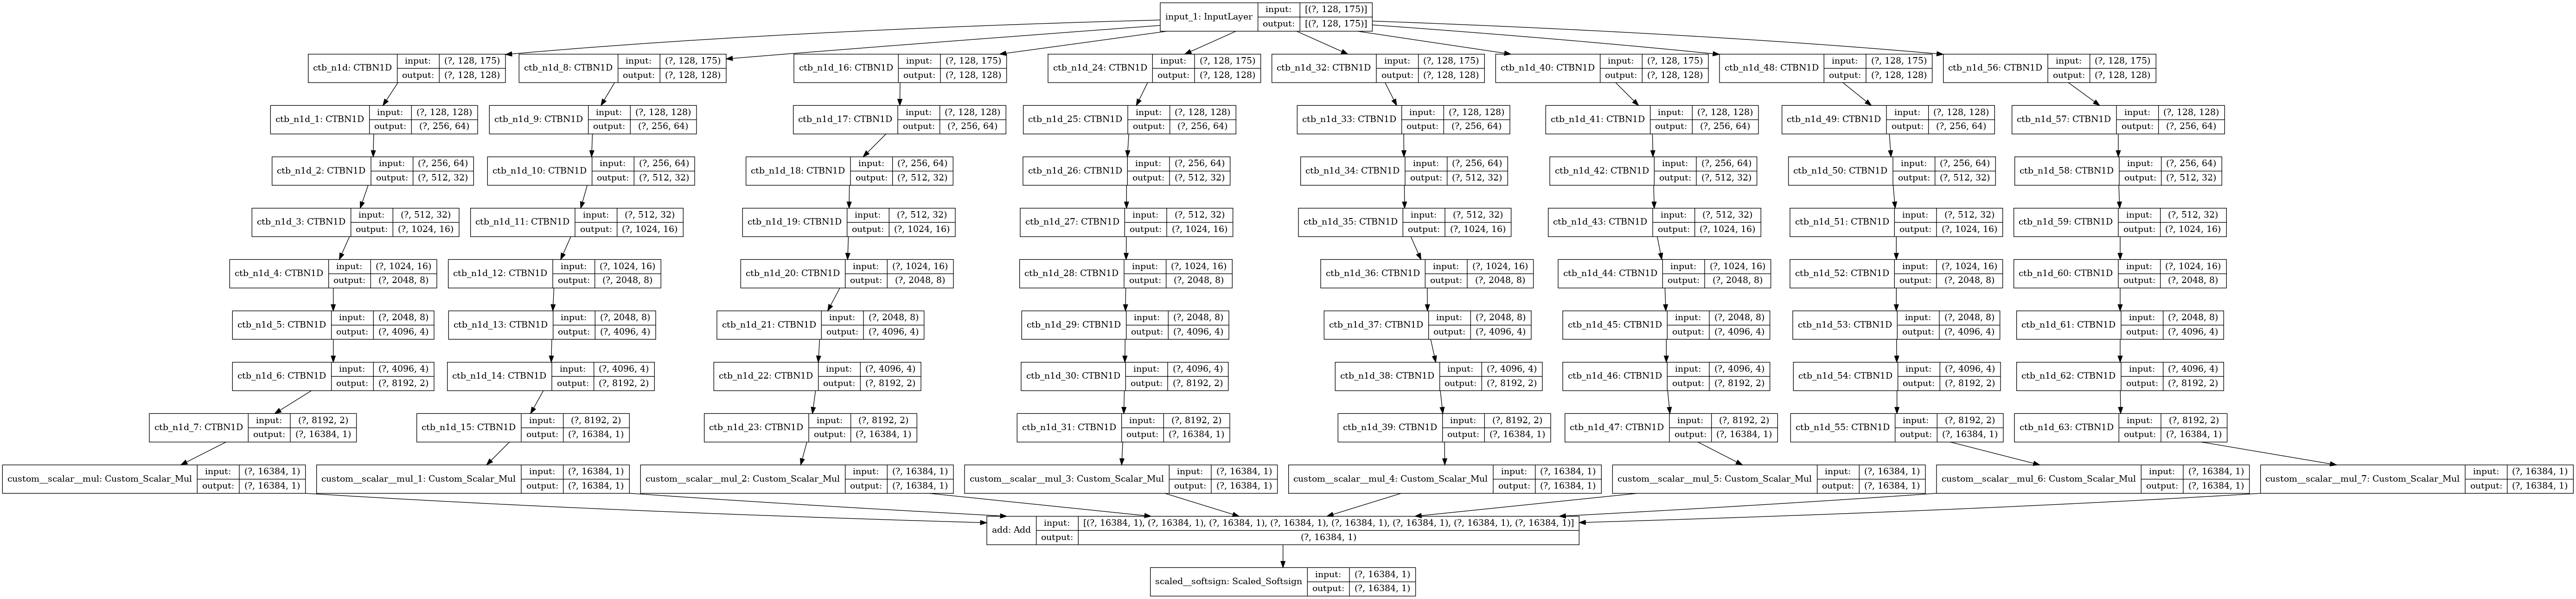

In [12]:
# create a graph of the model layers
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True,rankdir='TB',show_layer_names=True)

### Compile and train

In [13]:
model.compile(optimizer=optimizers.SGD(learning_rate=PARAMS['lr'],momentum=0.99,nesterov=True), loss=spectral_convergence)

In [37]:
history=model.fit(train_dataset,train_audio,
                epochs=PARAMS['n_epochs'],
                shuffle=True,validation_data=(valid_dataset,valid_audio))

#model.save(PARAMS['save_model'])

Epoch 1/100
183/183 [==============================] - 90s 493ms/step - loss: 0.4434 - val_loss: 0.4497
Epoch 2/100
183/183 [==============================] - 91s 495ms/step - loss: 0.4434 - val_loss: 0.4480
Epoch 3/100
183/183 [==============================] - 90s 494ms/step - loss: 0.4433 - val_loss: 0.4485
Epoch 4/100
183/183 [==============================] - 91s 495ms/step - loss: 0.4434 - val_loss: 0.4490
Epoch 5/100
183/183 [==============================] - 91s 495ms/step - loss: 0.4432 - val_loss: 0.4503
Epoch 6/100
183/183 [==============================] - 91s 496ms/step - loss: 0.4438 - val_loss: 0.4488
Epoch 7/100
183/183 [==============================] - 91s 496ms/step - loss: 0.4433 - val_loss: 0.4487
Epoch 8/100
183/183 [==============================] - 90s 494ms/step - loss: 0.4431 - val_loss: 0.4479
Epoch 9/100
183/183 [==============================] - 91s 495ms/step - loss: 0.4431 - val_loss: 0.4479
Epoch 10/100
183/183 [==============================] - 91s 495m

183/183 [==============================] - 90s 494ms/step - loss: 0.4424 - val_loss: 0.4469
Epoch 80/100
183/183 [==============================] - 90s 494ms/step - loss: 0.4425 - val_loss: 0.4468
Epoch 81/100
183/183 [==============================] - 90s 494ms/step - loss: 0.4424 - val_loss: 0.4468
Epoch 82/100
183/183 [==============================] - 90s 493ms/step - loss: 0.4422 - val_loss: 0.4469
Epoch 83/100
183/183 [==============================] - 90s 494ms/step - loss: 0.4423 - val_loss: 0.4467
Epoch 84/100
183/183 [==============================] - 90s 494ms/step - loss: 0.4421 - val_loss: 0.4481
Epoch 85/100
183/183 [==============================] - 90s 493ms/step - loss: 0.4427 - val_loss: 0.4472
Epoch 86/100
183/183 [==============================] - 90s 493ms/step - loss: 0.4425 - val_loss: 0.4465
Epoch 87/100
183/183 [==============================] - 90s 494ms/step - loss: 0.4422 - val_loss: 0.4466
Epoch 88/100
183/183 [==============================] - 90s 494ms/st

### Plot learning curves

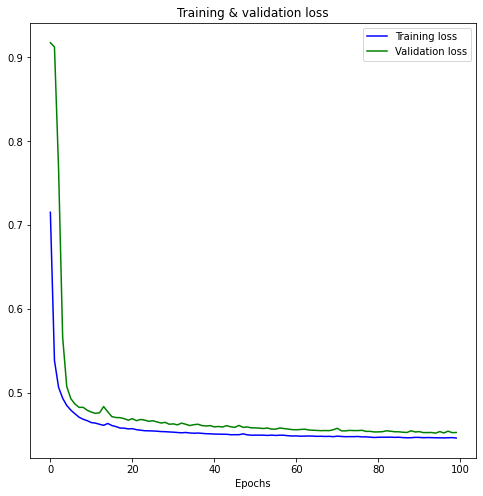

In [15]:
epoch_num=PARAMS['n_epochs']
loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8,8))
plt.plot(range(epoch_num), loss, 'b', label='Training loss')
plt.plot(range(epoch_num), val_loss, 'g', label='Validation loss')

plt.xlabel('Epochs')
plt.title('Training & validation loss')
plt.legend()
plt.show()

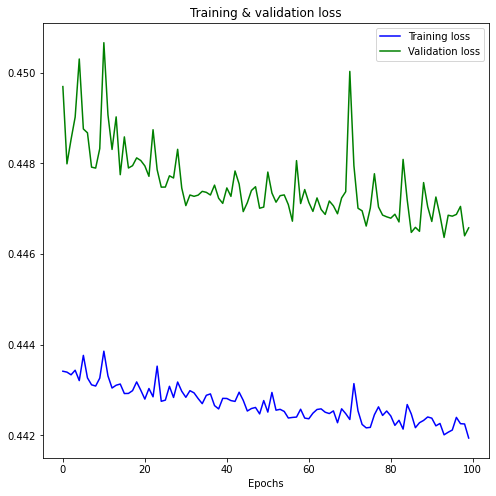

In [38]:
epoch_num=PARAMS['n_epochs']
loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8,8))
plt.plot(range(epoch_num), loss, 'b', label='Training loss')
plt.plot(range(epoch_num), val_loss, 'g', label='Validation loss')

plt.xlabel('Epochs')
plt.title('Training & validation loss')
plt.legend()
plt.show()

### Predict on subset of validation set

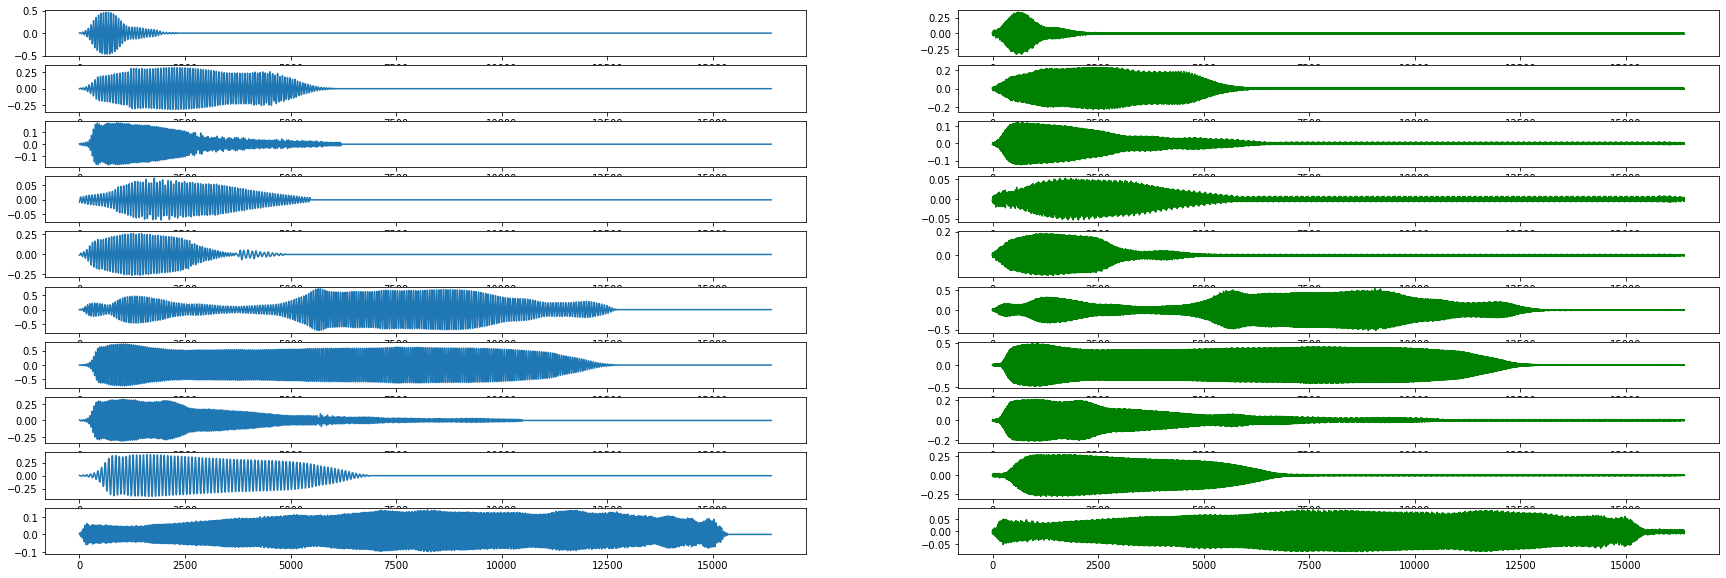

In [51]:
# choose number of examples from validation set to predict on and compare with original t-series signals


n = 10

orig_audio=[]
decoded_audio=[]
fig,axes=plt.subplots(n,2,figsize=(30,10))
for i in range(n):
    index=random.randrange(len(valid_dataset))
    
    out=model.predict(np.expand_dims(valid_dataset[index],axis=0))
    out=np.squeeze(out,axis=-1)
    out=np.squeeze(out,axis=0)
    audio=valid_audio[index]
    r=i
    ax=axes[r][0]
    ax.plot(audio)
    ax=axes[r][1]
    ax.plot(out,'g')

    orig_audio.append(audio)
    decoded_audio.append(out)
    
plt.show()



In [120]:
for i in range(n):
    display(IPython.display.Audio(orig_audio[i],rate=24414))
    print('original',i+1)
    display(IPython.display.Audio(decoded_audio[i],rate=24414))
    print('decoded',i+1)

original 1


decoded 1


original 2


decoded 2


original 3


decoded 3


original 4


decoded 4


original 5


decoded 5
